# Detect blob in consecutive section
1. Image segmentation: combine region and edge method 
2. Compute features of each cell using Yuncong's codes
3. For each cell, check if there's corresponding cells in the nearest neighbor sections

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv, rgb2gray
import pandas

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_cross_layer/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_cross_layer/

In [20]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 224
patch_half_size = patch_size / 2
stride = 56
# Crop images
# 
# crop_x_min = 9000
# crop_x_max = 10500
# crop_y_min = 3000
# crop_y_max = 4500

# #Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Brain Stem
# crop_x_min = 8000
# crop_x_max = 11000
# crop_y_min = 4000
# crop_y_max = 15000

# Half of the brain stem
# crop_x_min = 8000
# crop_x_max = 11000
# crop_y_min = 3000
# crop_y_max = 9500

# Whole
# crop_x_min = 0
# crop_y_min = 0
# _, _, crop_y_max, crop_x_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)

crop_image_width = crop_y_max - crop_y_min
crop_image_height = crop_x_max - crop_x_min

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;


In [21]:
# Set examine section number range and download from S3 if not available
img_filename = []
secIndexList = range(200, 201)
num_section = len(secIndexList)
for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image files are already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue

Image files are already available. 


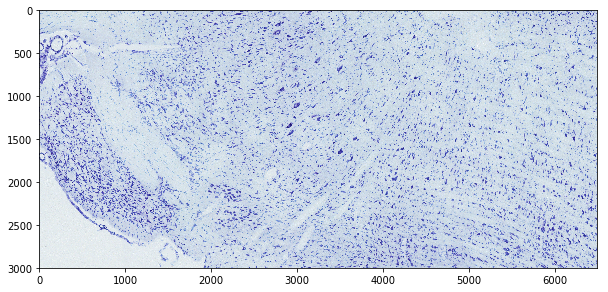

In [22]:
plt.figure(figsize=(10,10));
plt.imshow(imread(img_filename[0])[crop_x_min:crop_x_max, crop_y_min:crop_y_max]);

In [23]:
# sec = 192
# img_filename = DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='cropped')
# download_from_s3(img_filename)
im_cropped = [0 for tempI in range(num_section)]
for imIndex in range(num_section):
    tempImPath = img_filename[imIndex];
# for imIndex in [img_filename[0]]:
    im_cropped[imIndex] = imread(tempImPath)[crop_x_min:crop_x_max, crop_y_min:crop_y_max]
    im_cropped[imIndex] = rgb2gray(im_cropped[imIndex])
    im_cropped[imIndex]=img_as_ubyte(im_cropped[imIndex])
#     im_cropped[imIndex]=(img_as_ubyte(rgb2gray(imread(tempImPath))))
#     im_cropped = img_as_ubyte(rgb2gray(img_cropped))
    
im_cropped_h, im_cropped_w = im_cropped[0].shape[:2]

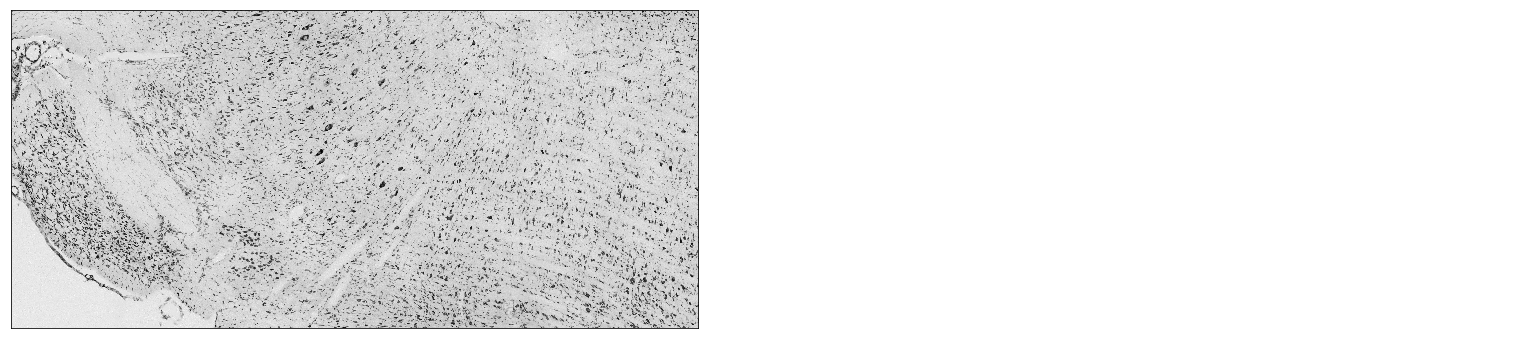

In [24]:
display_images_in_grids(im_cropped, nc = 2, cmap=plt.cm.gray)

In [25]:
img_cropped = im_cropped[0]

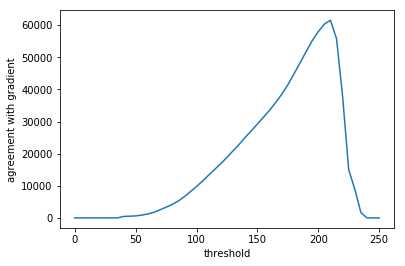

In [35]:
option_gaussian_filter = True
para_gaussian_filter_sigma = 5
if option_gaussian_filter:
    tempIm = ndi.filters.gaussian_filter(img_cropped,para_gaussian_filter_sigma)
# thresh_otsu = threshold_otsu(tempIm)
thresh_otsu = threshold_otsu(img_cropped)
gy, gx = np.gradient(img_as_ubyte(tempIm))
gy_abs = np.abs(gy)
gx_abs = np.abs(gx)

agreement_score = {}
# for threshold in np.arange(thresh_otsu-100, thresh_otsu+100, 2):
for threshold in np.arange(0, 255, 5):    
    gyb, gxb = np.gradient((tempIm < threshold ).astype(np.float))
    gyb_abs = np.abs(gyb)
    gxb_abs = np.abs(gxb)
    nz = (gyb_abs > 0) & (gxb_abs > 0)
    score = np.sqrt(np.sum(gyb_abs[nz]*gy_abs[nz]**2 + gxb_abs[nz]*gx_abs[nz]**2)).mean()
    agreement_score[threshold] = score

keys, values = zip(*sorted(agreement_score.items()))
plt.plot(keys, values);
plt.xlabel('threshold');
plt.ylabel('agreement with gradient');

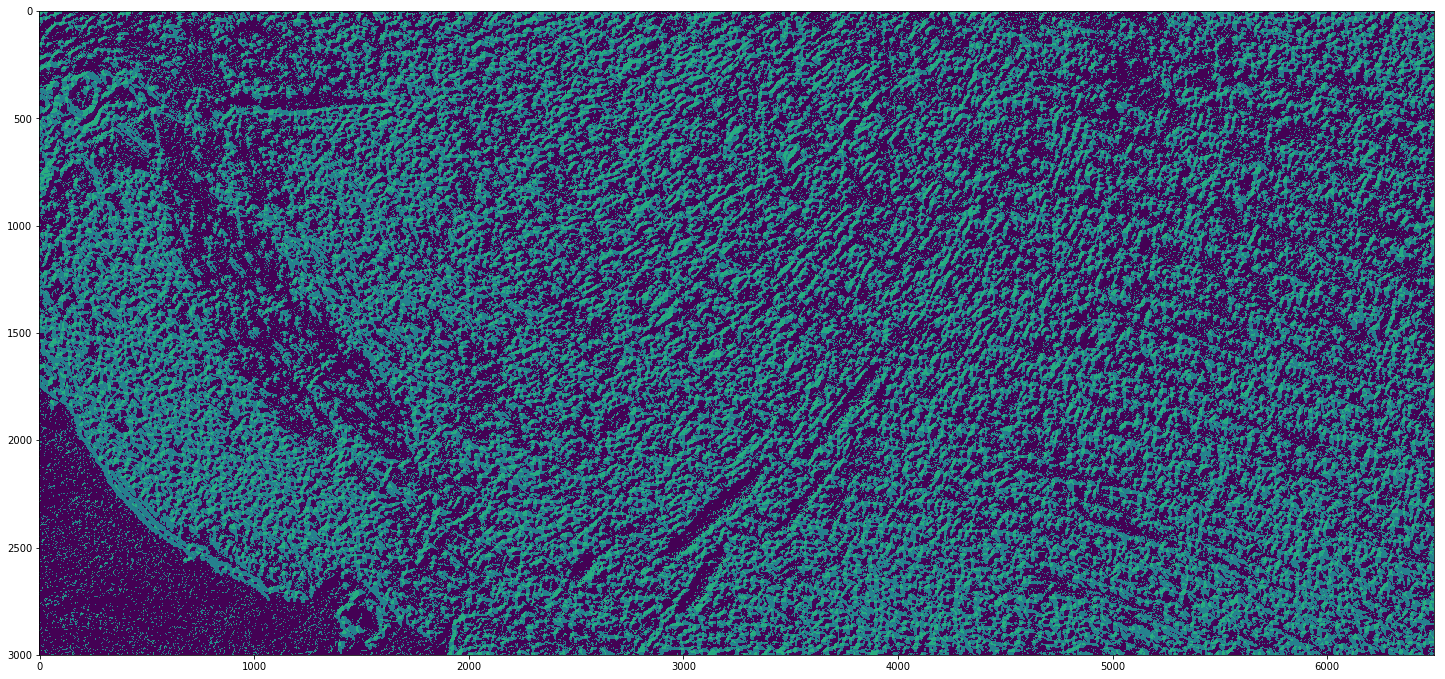

In [37]:
g_tot_abs = np.sqrt(gy ** 2 + gx ** 2);
plt.figure(figsize=(25,25))
plt.imshow(g_tot_abs)
# plt.colorbar()

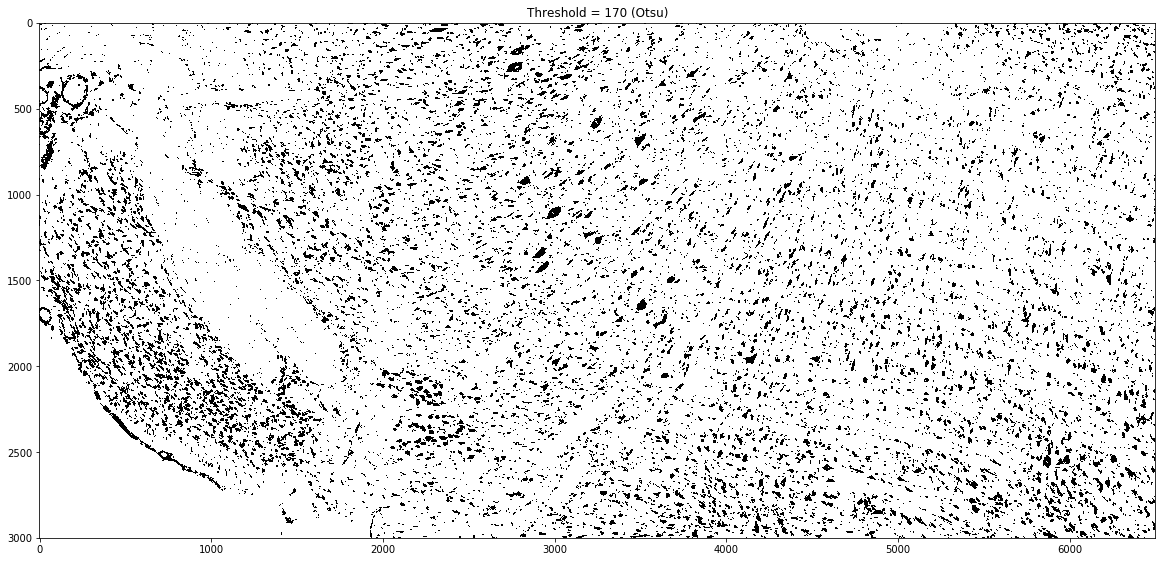

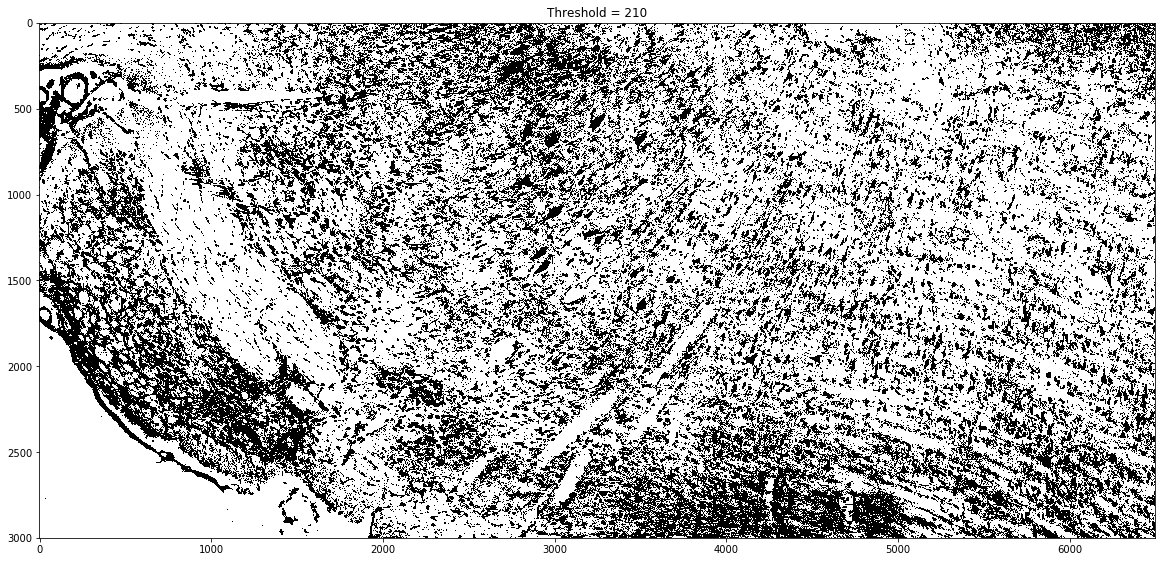

In [38]:
best_thresh_by_agreement = keys[np.argmax(values)]
# for threshold in np.arange(thresh_otsu-50, thresh_otsu+100, 20):
for threshold in [thresh_otsu, best_thresh_by_agreement]:
    
    if threshold > 256:
        break
    
#     viz = img_cropped_rgb.copy()
#     for cnt in find_contour_points(img_cropped < threshold)[1]:
#         cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, color=(255,0,0), thickness=2)
    
#     viz = img_as_ubyte(gaussian(img_cropped, sigma=5, preserve_range=True) < threshold)



#     viz = img_as_ubyte(img_cropped < threshold)

    plt.figure(figsize=(20, 20));
    if thresh_otsu == threshold:
        viz = img_as_ubyte(img_cropped > threshold)
        plt.title('Threshold = %d (Otsu)' % threshold);
    else:
        viz = img_as_ubyte(img_cropped > threshold)
        plt.title('Threshold = %d' % threshold);
    plt.imshow(viz, plt.cm.gray, vmin=0, vmax=255);
    plt.show();

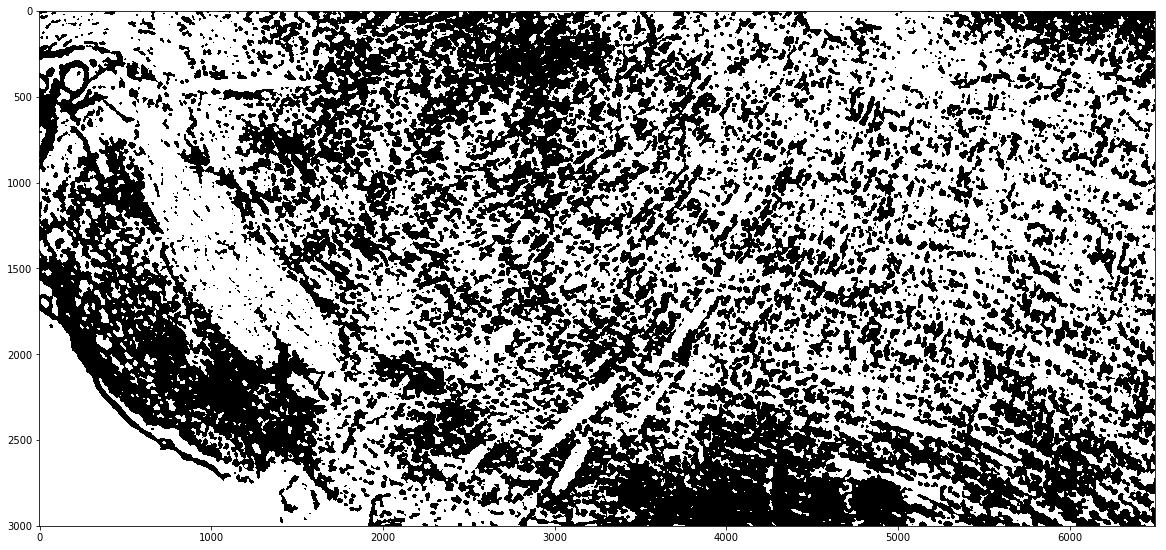

In [41]:
plt.figure(figsize=(20, 20));
plt.imshow(tempIm > threshold, plt.cm.gray);